In [136]:
import pandas as pd
import numpy as np 
import glob
import re
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text',usetex=True)
from scipy.optimize import curve_fit
import scipy as sci
from IPython.display import display, Latex

# Código para la caracterización y obtención de parámetros de un haz con archivos .xlsx dados por el programa de Beam Master
_Por Juan Carlos Rojas Velásquez_

La caracterización de las fuentes de luz de un montaje óptico es una parte importante al trabajar en óptica. La herramienta que tenemos en laboratorio de [Óptica Cuántica de la Universidad de Los Andes](https://opticacuantica.uniandes.edu.co/es/), llamada Beam Master de la marca Coherent, permite hacer esta caracterización. En este notebook se pretende utilizar los datos suministrados por el programa de Beam Master en formato **.xlsx** para encontrar los parámetros de waist de un haz ($w_0$), posición del waist del haz ($z_0$) y distancia de Rayleigh ($z_R$).

Para que la automatización del proceso sea exitosa, se debe tener una forma consistente de llamar los datos dados por el Beam Master a medida que estos se van registrando. Aquí un ejemplo: 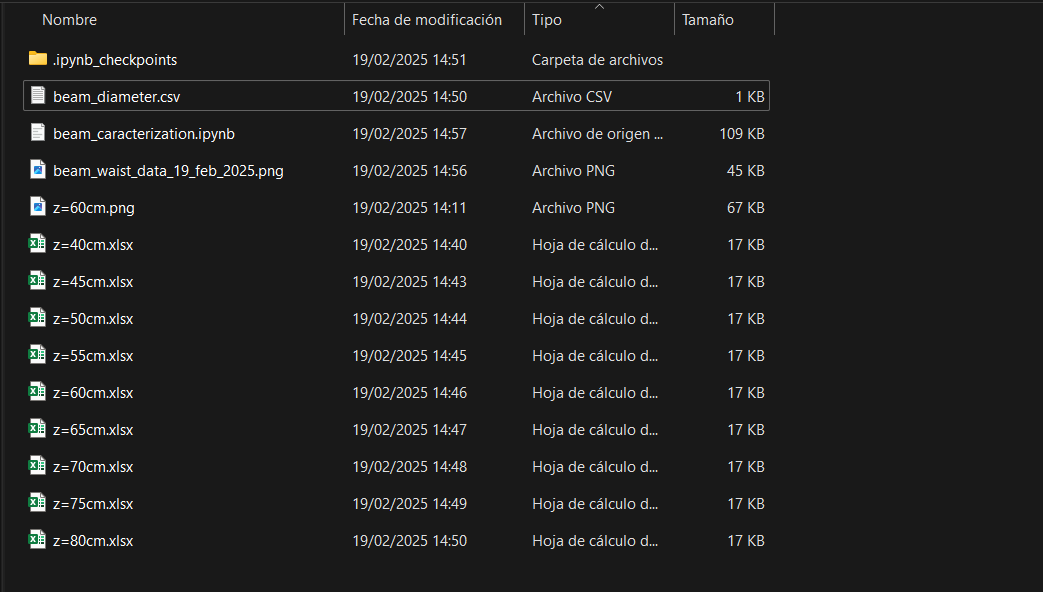

En la imagen se pueden ver varios archivos, entre ellos datos otorgados por el programa de Beam Master en el mismo tipo de archivo **.xlsx**. Como se puede ver, todos los archivos tienen nombres con el mismo formato (_z=XXcm.xlsx_); los archivos **deben** guardarse con un formato consistente el cual podrá ser modificado en la sección de _**Configuración de guardado de datos**_.

## Configuración de formato de guardado de datos

Para poder hacer el recorrido de los datos, se necesita tener un punto de partida ```posicion_inicial```, un punto final ``` posicion_final``` y cada cuanto se están tomando los datos ```distancia_entre_mediciones``` 

In [137]:
posicion_inicial = 0 # en centímetros
posicion_final = 55 # en centímetros
distancia_entre_mediciones = 5 # en centímetros

In [138]:
dataFrames_datos = {} #Diccionario donde se guardarán los datos de cada uno de los arvhivos .xlsx
N = 10 #Número de datos tomados ajustados en el logsetup
posiciones = []         # Lista con las posiciones
archivos = glob.glob("z*cm.xlsx")
for archivo in archivos:
    # Extraer el número (posicion) desde el nombre, por ejemplo "z85mm.xlsx" -> 85
    match = re.search(r"z(\d+)cm\.xlsx", archivo)
    if match:
        posicion = float(match.group(1))  # ahora en float
        posiciones.append(posicion)       # agrega la posición a la lista

        # Leer el archivo y recortar filas
        df = pd.read_excel(archivo, skiprows=20)
        dataFrames_datos[posicion] = df.iloc[:N+1]


Los datos de todos los archivos estarán guardados en el diccionario ```dataFrames_datos```. Si desea consultar los datos de un archivo específico, deberá escribir la posición **en números enteros** asociada al archivo a consultar en la variable ```archivo_consulta```. Es decir, si quisiera obtener información del archivo de datos que corresponde a la posición **45 cm** se escribiría: 

In [139]:
archivo_consulta = 15
dataFrames_datos[archivo_consulta]

,Time,Pos.X,W Width I,W Width II,W Width III,V Width I,V Width II,V Width III
0,(sec),(micron),(micron),(micron),(micron),(micron),(micron),(micron)
1,"0,0",0,1352,"724,2","390,5",1301,"713,3","392,5"
2,"0,2",0,1351,"718,0","393,3",1290,"711,5","394,7"
3,"0,4",0,1363,"714,4","381,7",1293,"712,9","393,0"
4,"0,6",0,1382,"724,8","392,8",1295,"717,9","403,5"
5,"0,8",0,1365,"716,1","397,3",1285,"724,5","407,4"
6,"1,0",0,1363,"724,1","386,1",1291,"714,3","402,7"
7,"1,2",0,1374,"720,0","395,0",1299,"719,4","408,2"
8,"1,4",0,1355,"716,3","396,0",1312,"717,5","403,3"
9,"1,6",0,1358,"718,7","388,2",1313,"724,8","404,3"


Dado que se necesita un único valor del waist del haz para cada posición, se promedian los valores de waist tomadas por el Beam Master para una posición específica. e.g. en la tabla anterior, se pueden ver 20 datos para _W Width I_ para la posición $z = 45 \ \text{cm}$, dado que únicamente se necesita un valor de _W Width I_ para $z = 45 \ \text{cm}$, se toma el promedio de los 20 datos.

In [140]:
lista_posiciones = posiciones
W_width_I = np.zeros_like(lista_posiciones,dtype=float)
V_width_I = np.zeros_like(lista_posiciones,dtype=float)

std_W_width_I = np.zeros_like(lista_posiciones,dtype=float)
std_V_width_I = np.zeros_like(lista_posiciones,dtype=float)

for i,posicion in enumerate(lista_posiciones):
    W_width_I[i] = ((dataFrames_datos[posicion]["W Width I"].to_numpy())[1:]/2*1e-6).mean()
    V_width_I[i] = ((dataFrames_datos[posicion]["V Width I"].to_numpy())[1:]/2*1e-6).mean()

    std_W_width_I[i] = ((dataFrames_datos[posicion]["W Width I"].to_numpy())[1:]/2*1e-6).std()
    std_V_width_I[i] = ((dataFrames_datos[posicion]["V Width I"].to_numpy())[1:]/2*1e-6).std()


pd.DataFrame({r"$z$":lista_posiciones,"W Width I": W_width_I,"V Width I":V_width_I, r"$\sigma_W$":std_W_width_I,r"$\sigma_V$":std_V_width_I})

,$z$,W Width I,V Width I,$\sigma_W$,$\sigma_V$
0,0.0,0.000663,0.000657,0.000005,0.000003
1,10.0,0.000683,0.000652,0.000002,0.000003
2,15.0,0.000681,0.000649,0.000005,0.000004
3,20.0,0.000695,0.000640,0.000003,0.000003
4,25.0,0.000695,0.000640,0.000002,0.000003
5,30.0,0.000707,0.000640,0.000004,0.000002
6,35.0,0.000721,0.000648,0.000002,0.000004
7,40.0,0.000731,0.000643,0.000004,0.000004
8,45.0,0.000738,0.000642,0.000004,0.000003
9,50.0,0.000741,0.000648,0.000005,0.000004


Ahora que existe un valor significativo para el waist del haz en ambas direcciones $W$ y $V$, se pueden hacer gráficas y ajustes sobre los datos para ver su comportamiento a diferentes valores en el eje de propagación $z$.

In [141]:
z = np.array(lista_posiciones)*1e-3
w_W= W_width_I 
w_V = V_width_I
sigma_w_W = std_W_width_I
sigma_w_V = std_V_width_I

## Gráfica del radio del haz en función de la posisción $z$

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

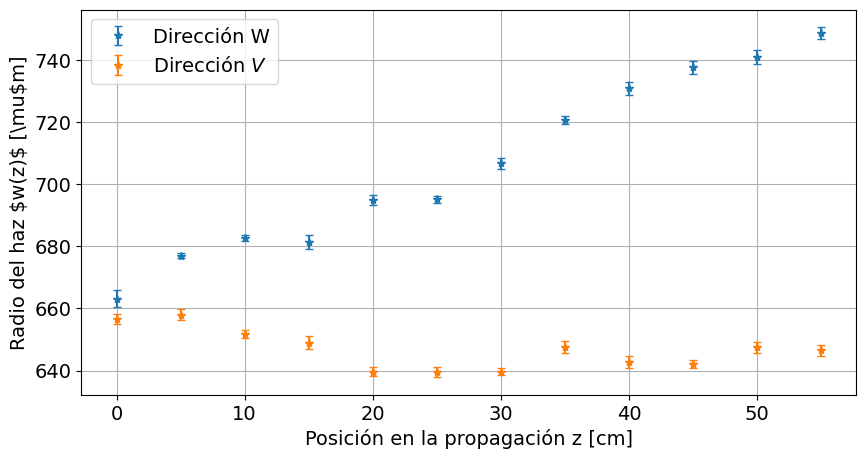

In [142]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

fig,ax = plt.subplots(figsize=(10,5))

plt.errorbar(z*1e3,w_W*1e6,sigma_w_W*1e6/2,fmt="*",label="Dirección W",capsize=3)
plt.xlabel(r"Posición en la propagación z [cm]")
plt.ylabel(r"Radio del haz $w(z)$ [\mu$m]")

plt.grid()
plt.errorbar(z*1e3,w_V*1e6,sigma_w_V*1e6/2,fmt="*",label="Dirección $V$",capsize=3)
plt.legend()

# Ajuste de parámetros del haz $w_0$, $z_{R}$ y $z_0$

Un haz gaussiano está caracterizado principalmente por dos parámetros: el waist o cintura del haz, denotado por $w_0$, que corresponde al radio más pequeño que puede alcanzar el láser en su propagación; y la distancia de Rayleigh, denotada por $z_R$, la cual corresponde a la distancia medida desde la posición en la que se encuentra $w_0$ hasta la posición donde el láser tiene un radio de $\sqrt{2}w_0$. Dentro de esta distancia, la luz del láser puede ser considerada como una onda plana. Para más información sobre la propagación de haces gaussianos puede visitar la página de Edmund Optics: [Gaussian Beam Propagation](https://www.edmundoptics.co.uk/knowledge-center/application-notes/lasers/gaussian-beam-propagation/). 

Teniendo en cuenta la fórmula para el waist del haz para diferentes valores de $z$: $$w(z) = w_0\sqrt{1 + \left( \frac{z - z_0}{z_R}\right)^2}$$ se pueden conseguir $w_0$, $z_R$ y $z_0$ por medio de un ajuste que siga la misma forma de los datos que se obtuvieron experimentalmente. Aquí, el parámetro $z_0$ indicará la posición donde se encuentra el mínimo radio del haz $w_0$.

In [143]:
def w(z,w_0,z_0,z_R):
    return w_0*np.sqrt(1 + ((z-z_0)/z_R)**2)

El ajuste de la función se hará por medio del paquete ```scipy.curvefit``` teniendo en cuenta el método de mínimos cuadrados no lineal. Si desea saber más acerca de este paquete, puede dirigirse a la [página de documentación de SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

In [144]:
params1,cov1 = curve_fit(w,z,w_W)
params2,cov2 = curve_fit(w,z,w_V)

A continuación se mostrarán los parámetros encontrado por ```scipy.curve_fit```. 

>[!CAUTION]
> Note que los valores reportados no tienen el número de cifras significativas adecuadas.
> Tenga cuidado al utilizar textualmente lo que aquí se reporta.

In [145]:
params1,params2,np.sqrt(np.diag(cov1)),np.sqrt(np.diag(cov2))

print(display(Latex(r"$w_0$ para la dirección W: $w_0 = (%s \pm %s)\ \mu\text{m}$"%(params1[0]*1e6,np.sqrt(np.diag(cov1))[0]*1e6))))
print(display(Latex(r"$z_0$ para la dirección W: $z_0 = (%s \pm %s)\ \text{cm}$"%(params1[1]*1e2,np.sqrt(np.diag(cov1)*1e2)[1]))))
print(display(Latex(r"$z_R$ para la dirección W: $z_R = (%s \pm %s)\ \text{cm}$"%(params1[2]*1e2,np.sqrt(np.diag(cov1)*1e2)[2]))))

print(45*"###")

print(display(Latex(r"$w_0$ para la dirección V: $w_0 = (%s \pm %s)\ \mu\text{m}$"%(params2[0]*1e6,np.sqrt(np.diag(cov2))[0]*1e6))))
print(display(Latex(r"$z_0$ para la dirección V: $z_0 = (%s \pm %s)\ \text{cm}$"%(params2[1]*1e2,np.sqrt(np.diag(cov2)*1e2)[1]))))
print(display(Latex(r"$z_R$ para la dirección V: $z_R = (%s \pm %s)\ \text{cm}$"%(params2[2]*1e2,np.sqrt(np.diag(cov2)*1e2)[2]))))


<IPython.core.display.Latex object>

None


<IPython.core.display.Latex object>

None


<IPython.core.display.Latex object>

None
#######################################################################################################################################


<IPython.core.display.Latex object>

None


<IPython.core.display.Latex object>

None


<IPython.core.display.Latex object>

None


In [146]:
z_linspace = np.linspace(lista_posiciones[0]+1,lista_posiciones[-1]+1)*1e-6
w_lins_W = w(z_linspace,params1[0],params1[1],params1[2])
w_lins_V = w(z_linspace,params2[0],params2[1],params2[2])

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

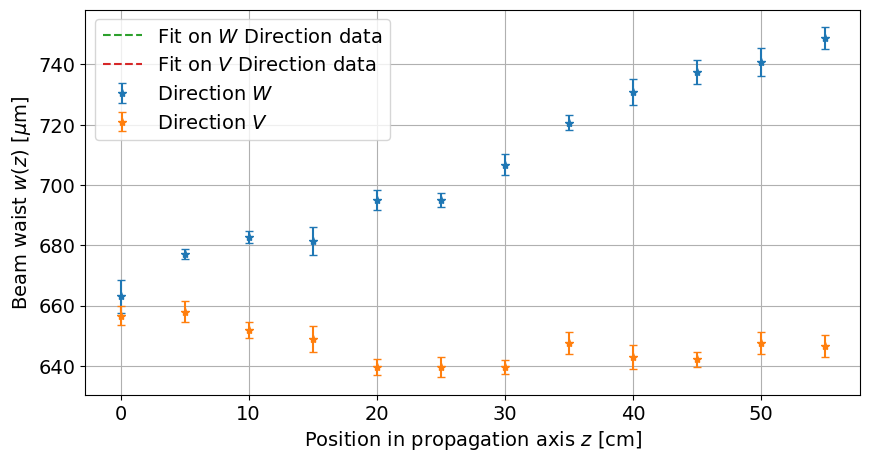

In [147]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
fig,ax = plt.subplots(figsize=(10,5))

plt.errorbar(z*1e3,w_W*1e6,sigma_w_W*1e6,fmt="*",label="Direction $W$",capsize=3)
plt.xlabel(r"Position in propagation axis $z$ [cm]")
plt.ylabel(r"Beam waist $w(z)$ [$\mu$m]")

plt.grid()
plt.errorbar(z*1e3,w_V*1e6,sigma_w_V*1e6,fmt="*",label="Direction $V$",capsize=3)
plt.plot(z_linspace*1e3,w_lins_W*1e6,"--",label="Fit on $W$ Direction data")
plt.plot(z_linspace*1e3,w_lins_V*1e6,"--",label="Fit on $V$ Direction data")

plt.legend()
#plt.savefig("DD-MM-AA-beam_waist_fit.pdf") # Se puede descomentar esta línea para que sea posible guardar la imagen que se muestra abajo.